In [1]:
from classy import Class
import numpy as np
from astropy.utils.data import get_pkg_data_filename
import astropy.io.fits as pyfits
import scipy
import matplotlib.pylab as plt
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import time as time
from scipy import integrate
from numpy import heaviside
from sklearn.model_selection import train_test_split
from fitter import Fitter, get_common_distributions, get_distributions
from colossus.cosmology import cosmology
from colossus.lss import mass_function
import scipy.integrate as integrate
from colossus.lss import bias
from scipy import special
from scipy.special import gamma
from astropy import units as u
from astropy.cosmology import Planck15 as cs
from astropy.cosmology import z_at_value
import warnings
from scipy.stats import chi2
import emcee
import corner
from halotools.mock_observables import tpcf
from halotools.mock_observables import wp
from astropy.coordinates import SkyCoord
warnings.filterwarnings("ignore")
from halotools.mock_observables import rp_pi_tpcf
import random
import hankl
import pyfftlog
from astropy.io import fits
import astropy
import PIL.Image
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

/opt/anaconda3/envs/env_healpy/lib/python3.9/site-packages/halotools/sim_manager/halo_table_cache.py:12: UserWarning: Some of the functionality of the HaloTableCache classrequires h5py to be installed.
  warn("Some of the functionality of the HaloTableCache class"
/opt/anaconda3/envs/env_healpy/lib/python3.9/site-packages/halotools/sim_manager/halo_table_cache_log_entry.py:14: UserWarning: Most of the functionality of the sim_manager sub-package requires h5py to be installed,
which can be accomplished either with pip or conda. 
  warn("Most of the functionality of the "
/opt/anaconda3/envs/env_healpy/lib/python3.9/site-packages/halotools/sim_manager/user_supplied_ptcl_catalog.py:13: UserWarning: Most of the functionality of the sim_manager sub-package requires h5py to be installed,
which can be accomplished either with pip or conda
  warn("Most of the functionality of the sim_manager "
/opt/anaconda3/envs/env_healpy/lib/python3.9/site-packages/halotools/sim_manager/ptcl_table_cache_log

In [2]:
#set the Cosmology

Omega_b = 0.05
Omega_m = 0.3
Omega_cdm = Omega_m - Omega_b
h = 0.7
A_s = 2.1e-9
n_s = 0.96

k_max = 1000 #UNITS: 1/Mpc

params = {
             'output':'mPk',
             'non linear':'halofit',
             'Omega_b':Omega_b,
             'Omega_cdm':Omega_cdm,
             'h':h,
             'A_s':A_s,
             'n_s':n_s,
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10
}

#Initialize the cosmology for linear matter power spectra computation
cosmo = Class()
cosmo.set(params)
cosmo.compute()

In [3]:
#2mass auto model

def P_1h_2MASS(M_i,M_f,k,z):
    sd_log_M=0.15
    def int_1h(M):
        dndm=(mass_function.massFunction(M*h, z, mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')*1/(M*h))*(h**4)
        n_sat=((M-M_0_2mass)/M_1_2mass)**alpha_2mass*heaviside(M-M_0_2mass,0)
        
        #usat calculation
        delta_vir=340 #define the cosmology
        m=M*h #set the M_vir=M, convert the unit from solar mass to solar mass * h^-1
    
        R=(m/(1.16e12*0.3))**(1/3)
    
    #constants
        R_star=3.135
        m_star=1.07e13
    
    
        c=9*(m/m_star)**(-0.13)
        #y=R/R_star
        y=6.9
        k_hat=(k/h)*R_star*(delta_vir)**(-1/3)
        kappa=k_hat*y/c
    
        si_c,ci_c=special.sici(kappa*(1+c))
        si_k,ci_k=special.sici(kappa)

    #compute the actual density
        x=np.sin(kappa)*(si_c-si_k)+np.cos(kappa)*(ci_c-ci_k)-np.sin(kappa*c)/(kappa*(1+c))
        f=1/(np.log(1+c)-c/(1+c))
        u=f*x

        return dndm*(2*n_sat*u+n_sat**2*u**2)
    
    def n_g_int(M):
        dndm=(mass_function.massFunction(M*h, z, mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')*1/(M*h))*(h**4)
        n_cen=1/2*(1+special.erf((np.log10(M)-np.log10(M_min_2mass))/sd_log_M))
        n_sat=((M-M_0_2mass)/M_1_2mass)**alpha_2mass*heaviside(M-M_0_2mass,0)
        return dndm*(n_cen+n_sat)

    ng=integrate.quad(n_g_int,M_i,M_f)[0]
    integral_1h=integrate.quad(int_1h,M_i,M_f)[0]
    
    P_g_1=ng**(-2)*integral_1h
    return P_g_1


def P_2h_2MASS(M_i,M_f,k,z):
    sd_log_M=0.15
    
        #return the P_g 2 halo terms in the unit of [Mpc^3]
    lin=cosmo.pk_lin(k, z)

    h=0.7
    sd_log_M=0.15
    M_0_2mass=M_min_2mass
    cosmology.setCosmology('planck15')
    def b_g_integration(M):
        #get the variables for integration
        dndm=(mass_function.massFunction(M*h, z, mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')*1/(M*h))*(h**4)
    
        n_cen=1/2*(1+special.erf((np.log10(M)-np.log10(M_min_2mass))/sd_log_M))
        n_sat=((M-M_0_2mass)/M_1_2mass)**alpha_2mass*heaviside(M-M_0_2mass,1)
        
        delta_vir=340 #define the cosmology
        m=M*h #set the M_vir=M, convert the unit from solar mass to solar mass * h^-1
    
        R=(m/(1.16e12*0.3))**(1/3)
    
    #constants
        R_star=3.135
        m_star=1.07e13
    
    
        c=9*(m/m_star)**(-0.13)
        y=R/R_star
        k_hat=(k/h)*R_star*(delta_vir)**(-1/3)
        kappa=k_hat*y/c
    
        si_c,ci_c=special.sici(kappa*(1+c))
        si_k,ci_k=special.sici(kappa)

    #compute the actual density
        x=np.sin(kappa)*(si_c-si_k)+np.cos(kappa)*(ci_c-ci_k)-np.sin(kappa*c)/(kappa*(1+c))
        f=1/(np.log(1+c)-c/(1+c))
        u=f*x*heaviside(r_max*h-R,1)
        
        #use the function from the package Colossus to compute the value of linear halo bias of Tinker et al. 2010
        b_1=bias.haloBias(M*h, z,mdef='vir',model='tinker10')
        return dndm*(n_cen+n_sat*u)*b_1
    
    def n_g_int(M):
        dndm=(mass_function.massFunction(M*h, z, mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')*1/(M*h))*(h**4)
        n_cen=1/2*(1+special.erf((np.log10(M)-np.log10(M_min_2mass))/sd_log_M))
        n_sat=((M-M_0_2mass)/M_1_2mass)**alpha_2mass*heaviside(M-M_0_2mass,1)
        return dndm*(n_cen+n_sat)

    ng=integrate.quad(n_g_int,M_i,M_f)[0]
    
#     x=np.linspace(M_i,M_f,20)
#     b_g_int=np.array([b_g_integration(ki) for ki in x])
#     bg=integrate.trapezoid(b_g_int,x)
    bg=integrate.quad(b_g_integration,M_i,M_f)[0]
    
    b_g=(1/ng)*bg

    return b_g*b_g*lin

In [4]:
def p_cross_1h(M_i,M_f,z,k):
    
    #alfalfa part
    h=0.7
    Omega_m=0.3
    Omega_lambda=0.7
    delta=180
    d_h=3000/h
    cosmology.setCosmology('planck15')
    sd_log_M=0.15
    rho_c=2.775*10**11
    rho_c_0=rho_c
    

    def F_1_halo_integrand(M,z,k):
        
        n=(mass_function.massFunction(M/h, z, mdef = 'vir', model = 'tinker08', q_out = 'M2dndM'))*(rho_c_0/M**2)
        #calculate M_HI
        R_v=(M*3/(4*np.pi)*1/(rho_c*Omega_m*delta))**(1/3) #virial radius
        c_HI=c_HI_0*(M/10**11)**(-0.109)*4/(1+z)**gamma
        r_s=R_v/c_HI

        M_HI=M_0_alfalfa*(M/M_min_alfalfa)**alpha_alfalfa*np.exp(-M_min_alfalfa/M)

        u_1=2*(1+k**2*r_s**2)**(-2)
#         u_1_1=-12*special.sici(0.75*k*r_s)[1]*np.sin(0.75*k*r_s)
#         u_1_2=12*special.sici((0.75+c_HI)*k*r_s)[1]*np.sin(0.75*k*r_s)
#         u_1_3=special.sici((1+c_HI)*k*r_s)[1]*(4*k*r_s*np.cos(k*r_s)-12*np.sin(k*r_s))
#         u_1_4=special.sici(k*r_s)[1]*(-4*k*r_s*np.cos(k*r_s)+12*np.sin(k*r_s))
#         u_1_5=-4*np.sin(c_HI*k*r_s)/(1+c_HI)
#         u_1_6=12*np.cos(0.75*k*r_s)*special.sici(0.75*k*r_s)[0]-12*np.cos(k*r_s)*special.sici(k*r_s)[0]
#         u_1_7=-4*k*r_s*np.sin(k*r_s)*special.sici(k*r_s)[0]
#         u_1_8=-12*np.cos(0.75*k*r_s)*special.sici((0.75+c_HI)*k*r_s)[0]
#         u_1_9=special.sici((1+c_HI)*k*r_s)[0]*(12*np.cos(k*r_s)+4*k*r_s*np.sin(k*r_s))

#         u_1=-(u_1_1+u_1_2+u_1_3+u_1_4+u_1_5+u_1_6+u_1_7+u_1_8+u_1_9)/(k*r_s)

        rho_0=M_HI/(8*np.pi*r_s**3)

        u_HI=4*np.pi*rho_0*r_s**3*u_1/M_HI

        return (M_HI*u_HI)

    def rho_mean_integrand(M,z):
        n=(mass_function.massFunction(M/h, z, mdef = 'vir', model = 'tinker08', q_out = 'M2dndM'))*(rho_c_0/M**2)
        M_HI=M_0_alfalfa*(M/M_min_alfalfa)**alpha_alfalfa*np.exp(-M_min_alfalfa/M)
        return n*M_HI


    
    #2MASS
    
    def F_1_2MASS_integrand(M,z,k):
        n_sat=((M-M_0_2mass)/M_1_2mass)**alpha_2mass*heaviside(M-M_0_2mass,0)
        
        #usat calculation
        delta_vir=340 #define the cosmology
        m=M*h #set the M_vir=M, convert the unit from solar mass to solar mass * h^-1
    
        R=(m/(1.16e12*0.3))**(1/3)
    
    #constants
        R_star=3.135
        m_star=1.07e13
    
    
        c=9*(m/m_star)**(-0.13)
        #y=R/R_star
        y=6.9
        k_hat=(k/h)*R_star*(delta_vir)**(-1/3)
        kappa=k_hat*y/c
    
        si_c,ci_c=special.sici(kappa*(1+c))
        si_k,ci_k=special.sici(kappa)

    #compute the actual density
        x=np.sin(kappa)*(si_c-si_k)+np.cos(kappa)*(ci_c-ci_k)-np.sin(kappa*c)/(kappa*(1+c))
        f=1/(np.log(1+c)-c/(1+c))
        u=f*x

        return np.sqrt(2*n_sat*u+n_sat**2*u**2)
    
    def n_g_int(M,z):
    
        dndm=(mass_function.massFunction(M/h, z, mdef = 'vir', model = 'tinker08', q_out = 'M2dndM'))*(rho_c_0/M**2)
        n_cen=1/2*(1+special.erf((np.log10(M)-np.log10(M_min_2mass))/sd_log_M))
        n_sat=((M-M_0_2mass)/M_1_2mass)**alpha_2mass*heaviside(M-M_0_2mass,1)
        return dndm*(n_cen+n_sat)
    
    
    def test(M,k,z):
        n=(mass_function.massFunction(M/h, z, mdef = 'vir', model = 'tinker08', q_out = 'M2dndM'))*(rho_c_0/M**2)
        return n*np.abs(F_1_halo_integrand(M,z,k))*np.abs(F_1_2MASS_integrand(M,z,k))
    
    x=np.logspace(np.log10(M_i),np.log10(M_f),num=100)
    y=np.array([test(xi,k,z) for xi in x])
    rho_alfalfa_arr=np.array([rho_mean_integrand(xi,z) for xi in x])
    rho_2mass_arr=np.array([n_g_int(xi,z) for xi in x])
    
    p_1h_int=np.trapz(y,x)
    rho_alfalfa=np.trapz(rho_alfalfa_arr,x)
    rho_2mass=np.trapz(rho_2mass_arr,x)
    
    
    
    return p_1h_int/(rho_alfalfa*rho_2mass)

In [5]:
# ALFALFA auto model
def P_1h_ALFALFA(M_i,M_f,k,z):
    h=0.7
    rho_c=2.775*10**11*0.7**2
    Omega_m=0.3
    Omega_lambda=0.7
    delta=180
    d_h=3000/h
    cosmology.setCosmology('planck15')

    def F_1_halo_integrand(M):

        n=(mass_function.massFunction(M*h, z, mdef = 'vir', model = 'tinker08', q_out = 'M2dndM'))*(rho_c/M**2)
        #calculate M_HI
        R_v=(M*3/(4*np.pi)*1/(rho_c*Omega_m*delta))**(1/3) #virial radius
        c_HI=c_HI_0*(M/10**11)**(-0.109)*4/(1+z)**gamma
        r_s=R_v/c_HI

        M_HI=M_0_alfalfa*(M/M_min_alfalfa)**alpha_alfalfa*np.exp(-M_min_alfalfa/M)

        #u_1=2*(1+k**2*r_s**2)**(-2)
        u_1_1=-12*special.sici(0.75*k*r_s)[1]*np.sin(0.75*k*r_s)
        u_1_2=12*special.sici((0.75+c_HI)*k*r_s)[1]*np.sin(0.75*k*r_s)
        u_1_3=special.sici((1+c_HI)*k*r_s)[1]*(4*k*r_s*np.cos(k*r_s)-12*np.sin(k*r_s))
        u_1_4=special.sici(k*r_s)[1]*(-4*k*r_s*np.cos(k*r_s)+12*np.sin(k*r_s))
        u_1_5=-4*np.sin(c_HI*k*r_s)/(1+c_HI)
        u_1_6=12*np.cos(0.75*k*r_s)*special.sici(0.75*k*r_s)[0]-12*np.cos(k*r_s)*special.sici(k*r_s)[0]
        u_1_7=-4*k*r_s*np.sin(k*r_s)*special.sici(k*r_s)[0]
        u_1_8=-12*np.cos(0.75*k*r_s)*special.sici((0.75+c_HI)*k*r_s)[0]
        u_1_9=special.sici((1+c_HI)*k*r_s)[0]*(12*np.cos(k*r_s)+4*k*r_s*np.sin(k*r_s))

        u_1=-(u_1_1+u_1_2+u_1_3+u_1_4+u_1_5+u_1_6+u_1_7+u_1_8+u_1_9)/(k*r_s)

        rho_0=M_HI/(8*np.pi*r_s**3)

        u_HI=4*np.pi*rho_0*r_s**3*u_1/M_HI

        return n*(M_HI*u_HI)**2

    def rho_mean_integrand(M):
        n=n=(mass_function.massFunction(M*h, z, mdef = 'vir', model = 'tinker08', q_out = 'M2dndM'))*(rho_c/M**2)
        M_HI=M_0_alfalfa*(M/M_min_alfalfa)**alpha_alfalfa*np.exp(-M_min_alfalfa/M)
        return n*M_HI

    #rho_mean=integrate.quad(rho_mean_integrand,M_i,M_f)[0]

    F_1_x=np.logspace(np.log10(M_i),np.log10(M_f),num=50)

    rho_y=np.array([rho_mean_integrand(mi) for mi in F_1_x])
    F_1_y=np.array([F_1_halo_integrand(mi) for mi in F_1_x])

    rho_mean=np.trapz(rho_y,F_1_x)
    F_1_halo=np.trapz(F_1_y,F_1_x)
        

    
    return F_1_halo/rho_mean**2

def P_2h_ALFALFA(M_i,M_f,k,z):
    h=0.7
    rho_c=2.775*10**11*0.7**2
    Omega_m=0.3
    Omega_lambda=0.7
    delta=180
    d_h=3000/h

    cosmology.setCosmology('planck15')
        
    def F_2_halo_integrand(M):
        n=(mass_function.massFunction(M*h, z, mdef = 'vir', model = 'tinker08', q_out = 'M2dndM'))*(rho_c/M**2)
        b=bias.haloBias(M*h, z,mdef='vir',model='tinker10')

        #calculate M_HI
        R_v=(M*3/(4*np.pi)/(rho_c*Omega_m*delta))**(1/3) #virial radius
        c_HI=c_HI_0*(M/10**11)**(-0.109)*4/(1+z)**gamma
        r_s=R_v/c_HI

        M_HI=M_0_alfalfa*(M/M_min_alfalfa)**alpha_alfalfa*np.exp(-M_min_alfalfa/M)

        #u_1=2*(1+k**2*r_s**2)**(-2)
        u_1_1=-12*special.sici(0.75*k*r_s)[1]*np.sin(0.75*k*r_s)
        u_1_2=12*special.sici((0.75+c_HI)*k*r_s)[1]*np.sin(0.75*k*r_s)
        u_1_3=special.sici((1+c_HI)*k*r_s)[1]*(4*k*r_s*np.cos(k*r_s)-12*np.sin(k*r_s))
        u_1_4=special.sici(k*r_s)[1]*(-4*k*r_s*np.cos(k*r_s)+12*np.sin(k*r_s))
        u_1_5=-4*np.sin(c_HI*k*r_s)/(1+c_HI)
        u_1_6=12*np.cos(0.75*k*r_s)*special.sici(0.75*k*r_s)[0]-12*np.cos(k*r_s)*special.sici(k*r_s)[0]
        u_1_7=-4*k*r_s*np.sin(k*r_s)*special.sici(k*r_s)[0]
        u_1_8=-12*np.cos(0.75*k*r_s)*special.sici((0.75+c_HI)*k*r_s)[0]
        u_1_9=special.sici((1+c_HI)*k*r_s)[0]*(12*np.cos(k*r_s)+4*k*r_s*np.sin(k*r_s))

        u_1=-(u_1_1+u_1_2+u_1_3+u_1_4+u_1_5+u_1_6+u_1_7+u_1_8+u_1_9)/(k*r_s)

        rho_0=M_HI/(8*np.pi*r_s**3)

        u_HI=4*np.pi*rho_0*r_s**3*u_1/M_HI

        return n*b*M_HI*u_HI

    def rho_mean_integrand(M):
        n=n=(mass_function.massFunction(M*h, z, mdef = 'vir', model = 'tinker08', q_out = 'M2dndM'))*(rho_c/M**2)
        M_HI=M_0_alfalfa*(M/M_min_alfalfa)**alpha_alfalfa*np.exp(-M_min_alfalfa/M)
        return n*M_HI

    F_2_x=np.logspace(np.log10(M_i),np.log10(M_f),num=50)

    rho_y=np.array([rho_mean_integrand(mi) for mi in F_2_x])
    F_2_y=np.array([F_2_halo_integrand(mi) for mi in F_2_x])

    rho_mean=np.trapz(rho_y,F_2_x)
    F_2_halo=np.trapz(F_2_y,F_2_x)/rho_mean


    Plin=cosmo.pk_lin(k, z)

    return Plin*F_2_halo**2


In [6]:
def p_cross_2h(M_i,M_f,z,k):
    
    h=0.7
    Omega_m=0.3
    Omega_lambda=0.7
    delta=180
    d_h=3000/h
    sd_log_M=0.15
    rho_c=2.775*10**11*h**2
    rho_c_0=rho_c/h**2

    cosmology.setCosmology('planck15')
    
    #alfalfa part
    
        
    def F_2_halo_integrand(M,z,k):
        n=(mass_function.massFunction(M/h, z, mdef = 'vir', model = 'tinker08', q_out = 'M2dndM'))*(rho_c_0/M**2)
        b=bias.haloBias(M/h, z,mdef='vir',model='tinker10')

        #calculate M_HI
        R_v=(M*3/(4*np.pi)/(rho_c*Omega_m*delta))**(1/3) #virial radius
        c_HI=c_HI_0*(M/10**11)**(-0.109)*4/(1+z)**gamma
        r_s=R_v/c_HI

        M_HI=M_0_alfalfa*(M/M_min_alfalfa)**alpha_alfalfa*np.exp(-M_min_alfalfa/M)

        u_1=2*(1+k**2*r_s**2)**(-2)
#         u_1_1=-12*special.sici(0.75*k*r_s)[1]*np.sin(0.75*k*r_s)
#         u_1_2=12*special.sici((0.75+c_HI)*k*r_s)[1]*np.sin(0.75*k*r_s)
#         u_1_3=special.sici((1+c_HI)*k*r_s)[1]*(4*k*r_s*np.cos(k*r_s)-12*np.sin(k*r_s))
#         u_1_4=special.sici(k*r_s)[1]*(-4*k*r_s*np.cos(k*r_s)+12*np.sin(k*r_s))
#         u_1_5=-4*np.sin(c_HI*k*r_s)/(1+c_HI)
        
#         u_1_6=12*np.cos(0.75*k*r_s)*special.sici(0.75*k*r_s)[0]-12*np.cos(k*r_s)*special.sici(k*r_s)[0]
#         u_1_7=-4*k*r_s*np.sin(k*r_s)*special.sici(k*r_s)[0]
#         u_1_8=-12*np.cos(0.75*k*r_s)*special.sici((0.75+c_HI)*k*r_s)[0]
#         u_1_9=special.sici((1+c_HI)*k*r_s)[0]*(12*np.cos(k*r_s)+4*k*r_s*np.sin(k*r_s))

#         u_1=-(u_1_1+u_1_2+u_1_3+u_1_4+u_1_5+u_1_6+u_1_7+u_1_8+u_1_9)/(k*r_s)

        rho_0=M_HI/(8*np.pi*r_s**3)

        u_HI=4*np.pi*rho_0*r_s**3*u_1/M_HI

        return n*b*M_HI*u_HI

    def rho_mean_integrand(M,z):
        n=(mass_function.massFunction(M/h, z, mdef = 'vir', model = 'tinker08', q_out = 'M2dndM'))*(rho_c_0/M**2)
        M_HI=M_0_alfalfa*(M/M_min_alfalfa)**alpha_alfalfa*np.exp(-M_min_alfalfa/M)
        return n*M_HI

        
    
    #2mass
    
    def b_g_integration(M,z,k):
        #get the variables for integration
        dndm=(mass_function.massFunction(M/h, z, mdef = 'vir', model = 'tinker08', q_out = 'M2dndM'))*(rho_c_0/M**2)
        
        n_cen=1/2*(1+special.erf((np.log10(M)-np.log10(M_min_2mass))/sd_log_M))
        n_sat=((M-M_0_2mass)/M_1_2mass)**alpha_2mass*heaviside(M-M_0_2mass,1)
        
        delta_vir=340 #define the cosmology
        m=M*h #set the M_vir=M, convert the unit from solar mass to solar mass * h^-1
    
        R=(m/(1.16e12*0.3))**(1/3)
    
    #constants
        R_star=3.135
        m_star=1.07e13
    
    
        c=9*(m/m_star)**(-0.13)
        y=R/R_star
        k_hat=(k/h)*R_star*(delta_vir)**(-1/3)
        kappa=k_hat*y/c
    
        si_c,ci_c=special.sici(kappa*(1+c))
        si_k,ci_k=special.sici(kappa)

    #compute the actual density
        x=np.sin(kappa)*(si_c-si_k)+np.cos(kappa)*(ci_c-ci_k)-np.sin(kappa*c)/(kappa*(1+c))
        f=1/(np.log(1+c)-c/(1+c))
        u=f*x*heaviside(r_max*h-R,1)
        
        #use the function from the package Colossus to compute the value of linear halo bias of Tinker et al. 2010
        b_1=bias.haloBias(M/h, z,mdef='vir',model='tinker10')
        return dndm*(n_cen+n_sat*u)*b_1
    
    def n_g_int(M,z):
    
        dndm=(mass_function.massFunction(M/h, z, mdef = 'vir', model = 'tinker08', q_out = 'M2dndM'))*(rho_c_0/M**2)
        n_cen=1/2*(1+special.erf((np.log10(M)-np.log10(M_min_2mass))/sd_log_M))
        n_sat=((M-M_0_2mass)/M_1_2mass)**alpha_2mass*heaviside(M-M_0_2mass,1)
        return dndm*(n_cen+n_sat)
    
    

    #calculation of angular power spectrum
        
        
    
    x=np.logspace(np.log10(M_i),np.log10(M_f),num=100)
    F_2h_arr=np.array([F_2_halo_integrand(xi,z,k) for xi in x])
    b_g_2mass_arr=np.array([b_g_integration(xi,z,k) for xi in x])
    rho_alfalfa_arr=np.array([rho_mean_integrand(xi,z) for xi in x])
    rho_2mass_arr=np.array([n_g_int(xi,z) for xi in x])
    
    
    F_2h=np.trapz(F_2h_arr,x)
    b_g_2mass=np.trapz(b_g_2mass_arr,x)
    rho_alfalfa=np.trapz(rho_alfalfa_arr,x)
    rho_2mass=np.trapz(rho_2mass_arr,x)
    Plin=cosmo.pk_lin(k, z)
    
    return Plin*F_2h*b_g_2mass/(rho_alfalfa*rho_2mass)
    

In [9]:
h=0.7
Omega_m=0.3
Omega_lambda=0.7
delta=180
d_h=3000/h
cosmology.setCosmology('planck15')
sd_log_M=0.15
rho_c=2.775*10**11
rho_c_0=rho_c
M_i=10**10
M_f=10**15
z=0.02

h=0.7
M_min_2mass=10**10
M_0_2mass=M_min_2mass
M_1_2mass=10**11.98
alpha_2mass=0.84
r_max=6.9

Omega_m=0.3
Omega_lambda=0.7
delta=180
c_HI_0=15.12
alpha_alfalfa=0.44
M_min_alfalfa=10**11.27
M_0_alfalfa=10**9.52
gamma=0
d_h=3000/h


kbins=np.logspace(-1,3,50)
Pbins_alfalfa_1h=np.array([])
Pbins_alfalfa_2h=np.array([])
Pbins_2mass_1h=np.array([])
Pbins_2mass_2h=np.array([])
Pbins_cross_1h=np.array([])
Pbins_cross_2h=np.array([])
for k_i in kbins:
    Pbins_alfalfa_1h=np.append(P_1h_ALFALFA(M_i,M_f,k_i,z),Pbins_alfalfa_1h)
    Pbins_alfalfa_2h=np.append(P_2h_ALFALFA(M_i,M_f,k_i,z),Pbins_alfalfa_2h)
    Pbins_2mass_1h=np.append(P_1h_2MASS(M_i,M_f,k_i,z),Pbins_2mass_1h)
    Pbins_2mass_2h=np.append(P_2h_2MASS(M_i,M_f,k_i,z),Pbins_2mass_2h)
    Pbins_cross_1h=np.append(p_cross_1h(M_i,M_f,z,k_i),Pbins_cross_1h)
    Pbins_cross_2h=np.append(p_cross_2h(M_i,M_f,z,k_i),Pbins_cross_2h)

Pbins_alfalfa=Pbins_alfalfa_1h+Pbins_alfalfa_2h
Pbins_2mass=Pbins_2mass_1h+Pbins_2mass_2h
Pbins_cross=Pbins_cross_1h+Pbins_cross_2h

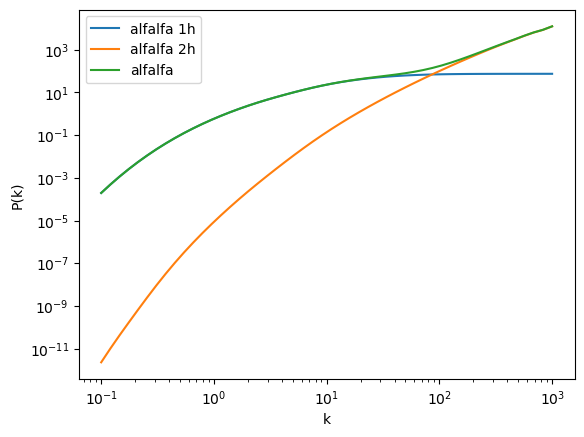

In [12]:
plt.loglog(kbins,Pbins_alfalfa_1h,label='alfalfa 1h')
plt.loglog(kbins,Pbins_alfalfa_2h,label='alfalfa 2h')
plt.loglog(kbins,Pbins_alfalfa,label='alfalfa')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend()
plt.show()

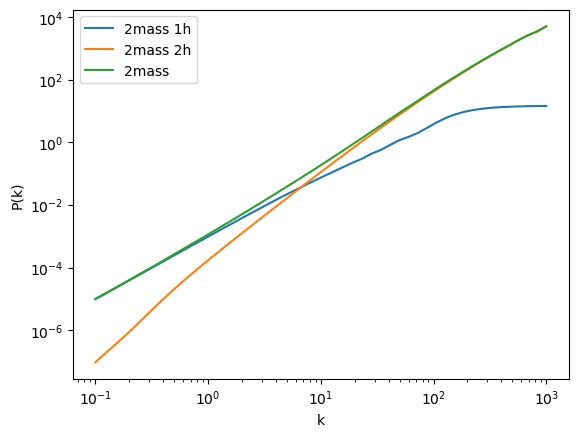

In [11]:
plt.loglog(kbins,Pbins_2mass_1h,label='2mass 1h')
plt.loglog(kbins,Pbins_2mass_2h,label='2mass 2h')
plt.loglog(kbins,Pbins_2mass,label='2mass')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend()
plt.show()